# Anomaly Detection with Autoencoders

## Libraries and Dataset Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [1]:
# general libraries
import numpy as np
import pandas as pd
import time
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

### MNIST and FASHION MNIST dataset 

For this notebook we will use two datasets:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)



In [2]:
from keras.datasets import mnist
import numpy as np
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

In [3]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [4]:
from keras.datasets import fashion_mnist
import numpy as np
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Note that we are doing the same normalisation for the fashion MNIST datasets as for the classical MNIST.

In [5]:
fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

## Problem to be solved

Now let's explain better what anomaly detection means. Let's create a special dataset that is made of the 10000 images of the MNIST test dataset and **one single** image from the fashion MNIST dataset. Our goal in this notebook will be to find this image automatically without looking at them. Can we do it?  

In [6]:
x_test = np.concatenate((mnist_x_test, fashion_x_test[0].reshape(1,784)))
print(x_test.shape)

(10001, 784)


All the images in the MNIST dataset are hand written digits. Below you can see an example of one of them.

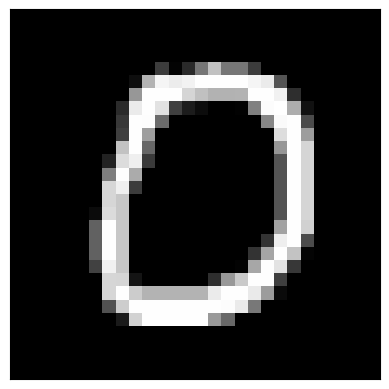

In [7]:
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(mnist_x_test[10].reshape(28, 28))

But the images in the fashion MNIST are all gray level images of clothing items. In particular the one we are adding to the hand written digits is the image of a shoe that can be seen below.

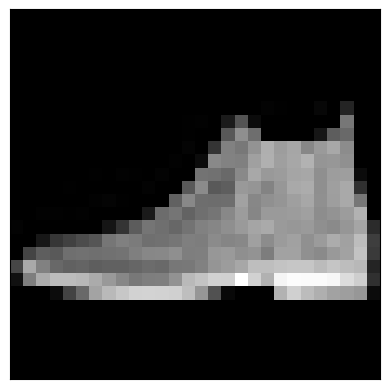

In [8]:
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(fashion_x_test[0].reshape(28, 28))
plt.show()

## Function to Create the Autoencoder

Now we need to create the ```keras``` model. An autoencoder is made of two main parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- the encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [9]:
def create_autoencoders(feature_layer_dim = 16):
  input_img = Input(shape = (784,), name = 'Input_Layer')
  # 784 is the total number of pixels of MNIST images

  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

## Autoencoder with layers with $(784,64,784)$ neurons.



As a first step let's create an autoencoder with the layer dimensions of $(784, 64, 784)$.




In [10]:
autoencoder, encoder, decoder = create_autoencoders(64)

In [14]:
keras.utils.plot_model(autoencoder, show_shapes = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


As for any Keras model we need to compile the model and fit it to the data. As you can see we don't need any custom code to work with autoencoders. A simple model **definition** $\rightarrow$ **compile** $\rightarrow$ **fit** is enough.

In [15]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [16]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                          epochs = 30,
                          batch_size = 256,
                          shuffle = True,
                          validation_data = (mnist_x_test, mnist_x_test),
                          verbose = 0)

In [17]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


We can now calculate the reconstruction error ($\textrm{RE}^{[j]}$) of image $j$ simply calculating

$$
\textrm{RE}^{[j]} = \sum_{i=1}^{784}\frac{(x_i^{[j]}-x_{rec,i}^{[j]})^2}{m}
$$

where $x_i^{[j]}$ is the $i^{th}$ pixel value of the $j$ image, and the sum is over all the pixels.

In [18]:
RE = ((x_test - decoded_imgs)**2).mean(axis = 1)
RE_original = RE.copy()

The $\textrm{RE}$ for the image of the shoe we added can be easily printed since it is the last element of the vector ```RE```.

In [20]:
RE[-1]

0.054284006

It is easy to see that this is the highest $\textrm{RE}$ we have for all 10000 images by far. We can check this by sorting the ```RE``` vector.

In [21]:
RE.sort()
print(RE[9990:])

[0.01749491 0.01778774 0.01827524 0.01833321 0.01845397 0.01901603
 0.02002052 0.0201214  0.02041499 0.02142187 0.05428401]


Notice that if you re-execute the whole notebook you can obtain slightly different results, due to the random initialization of the network's weights. 

You can see that the second highest reconstruction error (0.02129096) is less than half of the $\textrm{RE}$ for the added image (0.05436294). Below you can see the original image and the one that the trained autoencoder has reconstructed. You can see how the reconstructed image does not look like the original at all.

### Biggest RE

In [22]:
biggest_re_pos = np.argmax(RE_original)

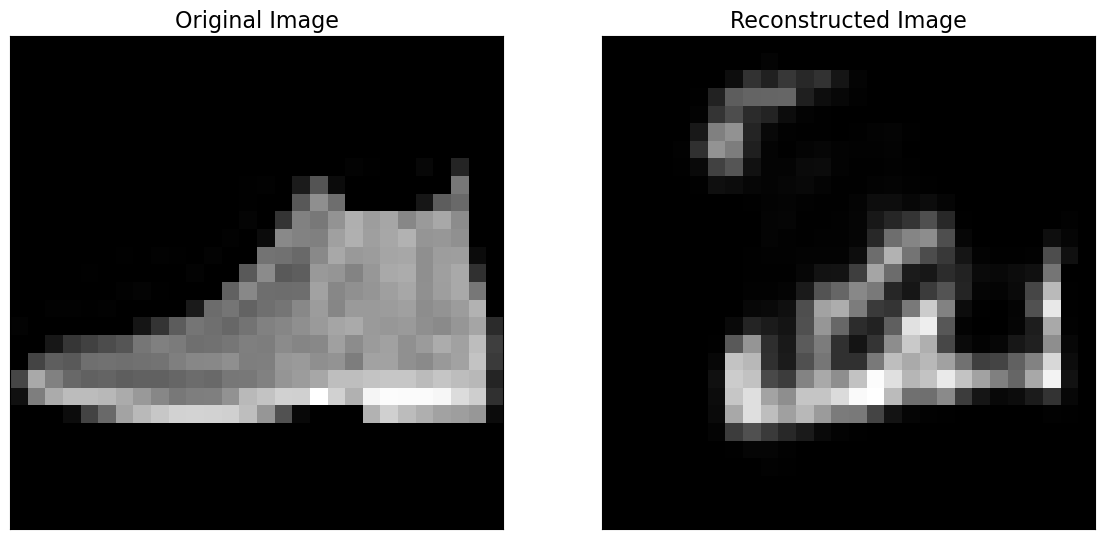

In [23]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)

plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(x_test[biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(1, 2, 2)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)

plt.imshow(decoded_imgs[biggest_re_pos].reshape(28, 28))

The autoencoder is able to reconstruct perfectly hand-written images, as you can see below.

### Second biggest RE

The image shown below (and its reconstructed version) is the one with the second highest reconstruction error. The reason is clear, this image does not seems like a hand-written digit at all! That could even count as an outlier in the dataset.

In [24]:
second_biggest_re_pos = list(RE_original).index(RE[-2])

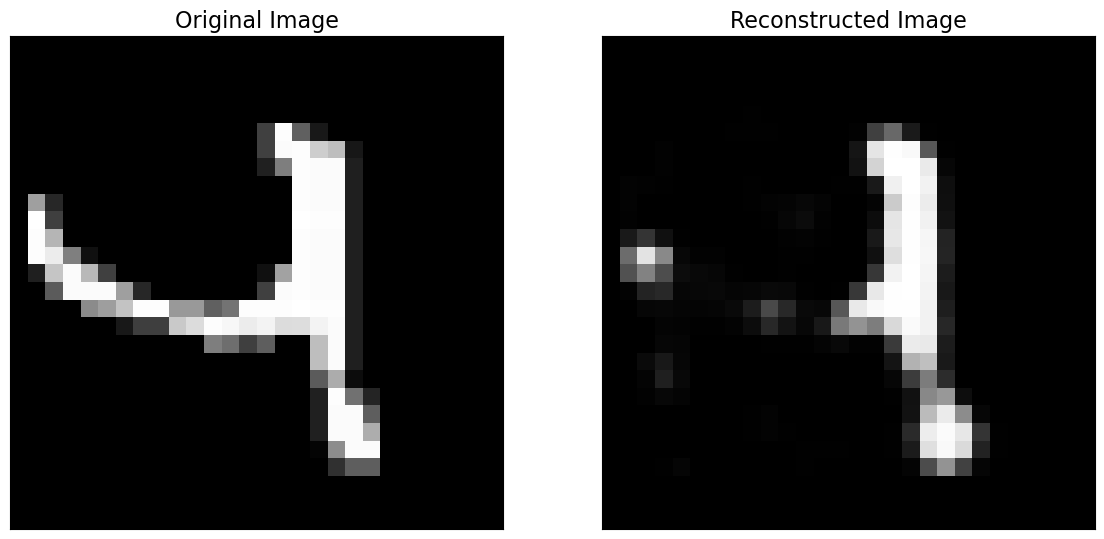

In [25]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)
plt.title('Original Image', fontsize = 16)
plt.gray()
plt.imshow(x_test[second_biggest_re_pos].reshape(28, 28))

ax = fig.add_subplot(1, 2, 2)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, 
                labelbottom = False) 
plt.tick_params(axis = 'y', which = 'both', left = False, right = False, 
                labelleft = False)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.imshow(decoded_imgs[second_biggest_re_pos].reshape(28, 28))

### Third biggest RE

In [26]:
third_biggest_re_pos = list(RE_original).index(RE[-3])

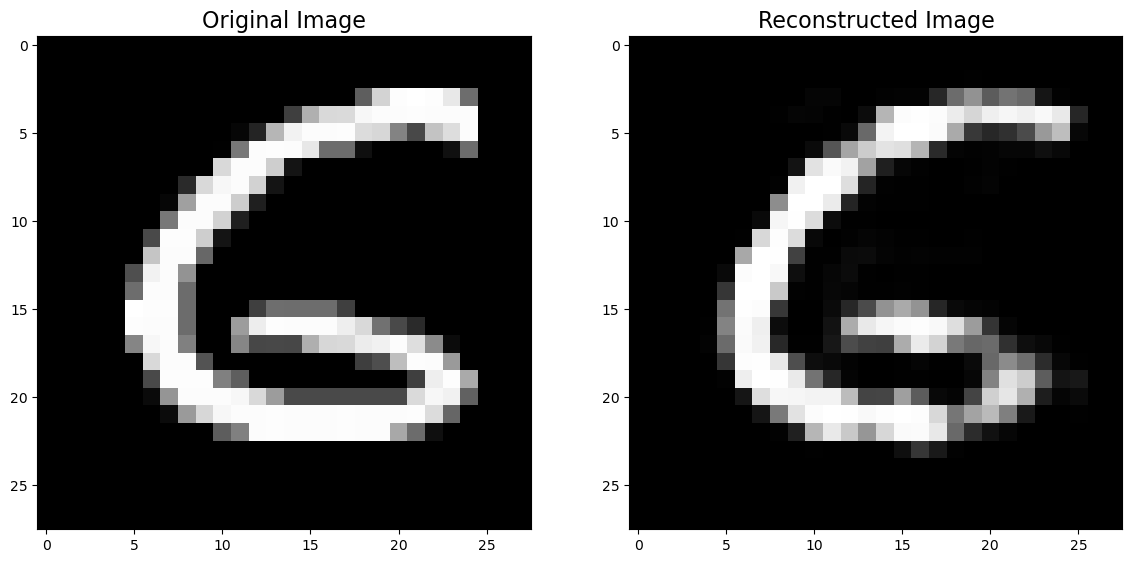

In [27]:
fig = plt.figure(figsize = (14, 7))

ax = fig.add_subplot(1, 2, 1)
plt.title('Original Image', fontsize = 16)
plt.gray()
plt.imshow(x_test[third_biggest_re_pos].reshape(28,28))

ax = fig.add_subplot(1, 2, 2)
plt.title('Reconstructed Image', fontsize = 16)
plt.gray()
plt.imshow(decoded_imgs[third_biggest_re_pos].reshape(28,28))